# 1.0 Attention & Visual Attention

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt  
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging

In [3]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [4]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention]) 

# 3.0 Build a Model

## 3.1 Download a dataset (CIFAR 10)

In [5]:
fpath = 'C:/Users/lesly/Mineria/Unidad3/Proy_Mineria/Lab1/eliminar_ruido'
categories = os.listdir(fpath)
IMG_SHAPE  = 100
batch_size = 32
random_seed = 9
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['con_mascara', 'sin_mascara'] 

No. of categories =  2


In [6]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  6716 
No. of labels loaded =  6716
<class 'list'> <class 'list'>


In [7]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (6716, 100, 100, 3) 
Labels shape =  (6716,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


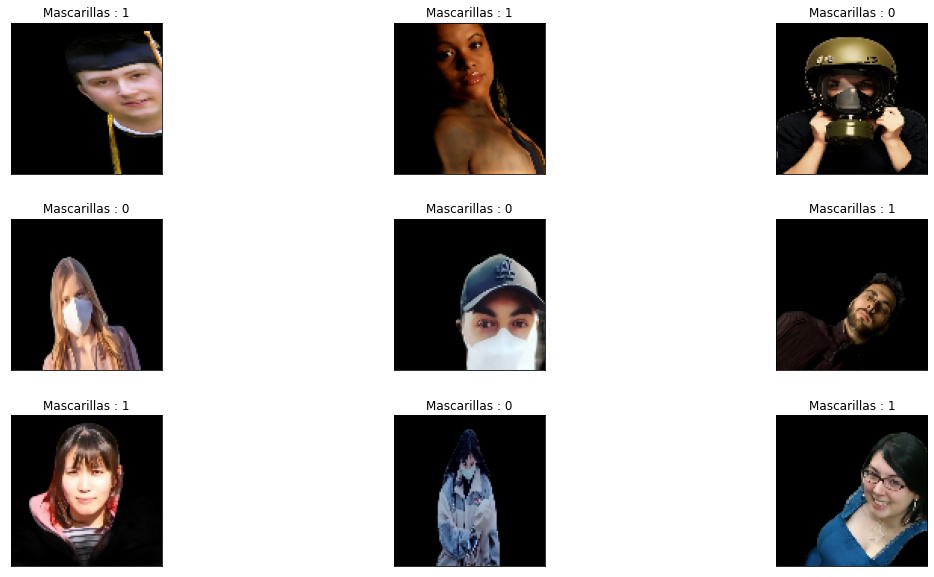

In [8]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Mascarillas : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

In [9]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 6713 6714 6715]

'n' values after shuffling =  [4947 3648 5547 ...  501 4444  382]


In [10]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (6716, 100, 100, 3) 
Labels shape after shuffling =  (6716,)


In [11]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (6716, 100, 100, 3)


In [12]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (5314, 100, 100, 3)
y_train shape =  (5314,)

x_test shape =  (1344, 100, 100, 3)
y_test shape =  (1344,)

x_val shape =  (58, 100, 100, 3)
y_val shape =  (58,)


In [13]:
##One-hot-encode
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)

### 3.1.1 Visualize the dataset

### 3.1.2 Build a dataset pipeline

## 3.3 Builid a network with attention

In [14]:
simple_cnn_with_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape = x_train[0].shape, activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='sigmoid' )
])

In [15]:
simple_cnn_with_attention.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
channel_attention (ChannelAt (None, 100, 100, 32)      0         
_________________________________________________________________
spatial_attention (SpatialAt (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0

In [16]:
simple_cnn_with_attention.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [17]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [19]:
history = simple_cnn_with_attention.fit(x_train, y_train,validation_split=0.2, epochs=50)

Epoch 1/50
133/133 [==============================] - 141s 1s/step - loss: 0.6274 - accuracy: 0.6744 - val_loss: 1.7551 - val_accuracy: 0.5221
Epoch 2/50
133/133 [==============================] - 150s 1s/step - loss: 0.5345 - accuracy: 0.7455 - val_loss: 1.6810 - val_accuracy: 0.4751
Epoch 3/50
133/133 [==============================] - 135s 1s/step - loss: 0.4642 - accuracy: 0.7880 - val_loss: 0.9518 - val_accuracy: 0.5230
Epoch 4/50
133/133 [==============================] - 138s 1s/step - loss: 0.3788 - accuracy: 0.8379 - val_loss: 0.3592 - val_accuracy: 0.8250
Epoch 5/50
133/133 [==============================] - 139s 1s/step - loss: 0.3259 - accuracy: 0.8671 - val_loss: 0.3797 - val_accuracy: 0.8674
Epoch 6/50
133/133 [==============================] - 144s 1s/step - loss: 0.2838 - accuracy: 0.8866 - val_loss: 0.4577 - val_accuracy: 0.8288
Epoch 7/50
133/133 [==============================] - 166s 1s/step - loss: 0.2369 - accuracy: 0.9104 - val_loss: 0.3594 - val_accuracy: 0.8354

In [20]:
start_time = time.time()

loss, accuracy = simple_cnn_with_attention.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

42/42 [==============================] - 11s 247ms/step - loss: 0.1288 - accuracy: 0.9740
test_loss: 12.88
test_accuracy: 97.40


In [21]:
model_probs = simple_cnn_with_attention.predict(x_test,batch_size=batch_size,verbose=0)
y_pred = model_probs
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 97.40
F1 score: 97.40
Precision: 97.40
Recall: 97.40


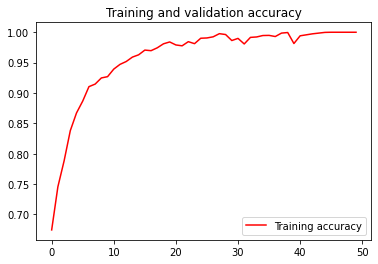

In [22]:
accuracy = history.history['accuracy'] 
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy') 
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN_AttentionModule.png")
plt.show() 

In [23]:
model_probs.round();

In [24]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1)

In [25]:
import pandas as pd
matriz_Confusion = pd.crosstab(Y_true, Y_pred_classes, rownames=['Actual'], colnames=['Predicción'])
matriz_Confusion

Predicción,0,1
Actual,,
0,647,19
1,16,662


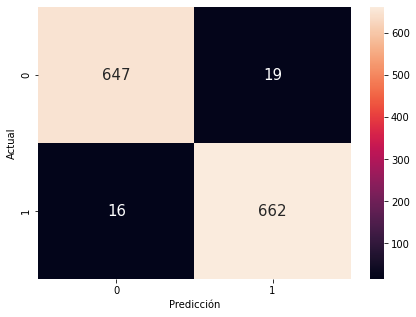

In [26]:
import seaborn as sns
plt.figure(figsize=(7, 5))

sns.heatmap(matriz_Confusion, annot=True,  annot_kws={'size': 15}, fmt = "d")
plt.show()